# Omer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
import datetime
warnings.filterwarnings('ignore')
warnings.warn('this will not show')
sns.set(style='darkgrid')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/withoutNAN.pickle')

In [4]:
df=data.copy()

In [ ]:
def replace_outliers(s, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.
  indexes = s.dropna().index
  col = s.dropna()
  iqr = (np.quantile(col, 0.75))-(np.quantile(col, 0.25))
  upper_bound = np.quantile(col, 0.75)+(whisker*iqr)
  lower_bound = np.quantile(col, 0.25)-(whisker*iqr)
  upper_bound = upper_bound if upper_bound < col.max() else col.max(),
  lower_bound = lower_bound if lower_bound > col.min() else col.min(),

  if replaced_value=='median':
    col = col.mask(col > upper_bound, col.median())
    col = col.mask(col < lower_bound, col.median())
  elif replaced_value=='mean':
    col = col.mask(col > upper_bound, col.mean())
    col = col.mask(col < lower_bound, col.mean())
  elif replaced_value=='mode':
    col = col.mask(df[col] > upper_bound, col.mode()[0])
    col = col.mask(df[col] < lower_bound, col.mode()[0])
  else:
    col = col.mask(col > upper_bound, replaced_value)
    col= col.mask(col < lower_bound, replaced_value)   

  plt.figure(figsize=(8,3))
  sns.boxplot(x= col)
  plt.show()
  s[indexes]=col
  return s


def outliers(s):
  # summary of the outliers
  s=s.dropna()
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  count = int(len(f))
  pros = len(f)/len(s)
  d = {'IQR':iqr,
      'Lower Bound':lower_bound if lower_bound > s.min() else s.min(),
       'Q1':np.quantile(s, 0.25),
       'Q2':np.quantile(s, 0.50),
       'Q3':np.quantile(s, 0.75),
      'Upper Bound':upper_bound if upper_bound < s.max() else s.max(),
      'Count of Outliers': count,'Percentage of Outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['count','values'])
  return(d)

def capping_outliers(s, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values
  indexes = s.dropna().index
  col = s.dropna()
  iqr = (np.quantile(col, 0.75))-(np.quantile(col, 0.25))
  upper_bound = np.quantile(col, 0.75)+(whisker*iqr)
  lower_bound = np.quantile(col, 0.25)-(whisker*iqr)
  upper_bound = upper_bound if upper_bound < col.max() else col.max(),
  lower_bound = lower_bound if lower_bound > col.min() else col.min(),

  col = np.where(col > upper_bound, upper_bound,col)
  col = np.where(col < lower_bound, lower_bound,col)
  plt.figure(figsize=(8,3))
  sns.boxplot(x= col)
  plt.show()
  s[indexes]=col
  return s

In [ ]:
from scipy.stats.mstats import winsorize
def col_plot(df,col_name,up=0.1,down=0, iqr=1.5):
  
  f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
  f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
  root= df[col_name].apply(f_sqrt)
  log= df[col_name].apply(f_log)
  winsor= winsorize(df[col_name], (down,up))
  root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

  plt.figure(figsize=(35,15))
  plt.suptitle(col_name,fontsize=20)

  plt.subplot(251) # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
  plt.hist(df[col_name], bins = 20)
  plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
  plt.axvline(x=df[col_name].mean(),color='black',linewidth=4)
  plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
  plt.tight_layout
  plt.xlabel("Histogram ±3z")
  plt.ylabel(col_name)

  plt.subplot(252) # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
  plt.hist(winsor, bins = 22)
  plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
  plt.axvline(x=winsor.mean(),color='black',linewidth=4)
  plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
  plt.xlabel('WINSORIZE_Histogram ±3z')
  plt.ylabel(col_name)
  plt.tight_layout

  plt.subplot(253)
  plt.hist(root, bins=22)
  plt.axvline(x=root.mean()+3*root.std(),color='red')
  plt.axvline(x=root.mean()-3*root.std(),color='red')
  plt.xlabel('ROOT_Histogram ±3z')

  plt.subplot(254)
  plt.hist(log, bins=22)
  plt.axvline(x=log.mean()+3*log.std(),color='red')
  plt.axvline(x=log.mean()-3*log.std(),color='red')
  plt.xlabel('LOG_Histogram ±3z')

  plt.subplot(255)
  plt.hist(log, bins=22)
  plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
  plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
  plt.xlabel('ROOT-WINSORIZE_Histogram ±3z')

  plt.subplot(256)
  plt.boxplot(df[col_name], whis = iqr)
  plt.xlabel(f"IQR:{iqr}")

  plt.subplot(257)
  plt.boxplot(winsor, whis = iqr)
  plt.xlabel(f'WINSORIZE - IQR:{iqr}')

  plt.subplot(258)
  plt.boxplot(root, whis = iqr)
  plt.xlabel(f"ROOT - IQR:{iqr}")

  plt.subplot(259)
  plt.boxplot(log, whis = iqr)
  plt.xlabel(f"LOG - IQR:{iqr}")

  plt.subplot(2,5,10)
  plt.boxplot(log, whis = iqr)
  plt.xlabel(f"ROOT & WINSORIZE - IQR:{iqr}")
  plt.show()

def pol_twin(df, col, target, figsize=(10,6)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  df[col].value_counts(dropna=False, normalize=True).sort_index().plot.bar(ax= ax)
  ax_twin = ax.twinx()
  df.groupby(col)[target].mean().plot.line(ax=ax_twin, color='red', marker='o', ms=10)
  ax.grid()
  ax_twin.legend()
  ax.legend();

In [7]:
def crosstab(df):
    num_df=df.select_dtypes(include=[np.number]).columns.tolist()#numerical columns as a list
    cat_df=df.select_dtypes(exclude=[np.number]).columns.tolist()#categorical columns as a list
    num_df1=df.select_dtypes(include=[np.number])
    cat_df1=df.select_dtypes(exclude=[np.number])
    print("The categorical fields in the dataset are",cat_df)#displaying categorical variables 
    a = int(input("enter the first categorical column to find the relationship: "))#user input for first categorical variable 
    b = int(input("enter the second categorical column to find the relationship: "))#user input for second categorical variable
    #calculating the crosstabs for two categorical variables
    print((pd.crosstab(cat_df1.iloc[:,a-1],cat_df1.iloc[:,b-1],normalize=False,margins=True, margins_name="Total")).round(2))
    #displaying the crosstabs as mutiple bar plot
    (pd.crosstab(cat_df1.iloc[:,a-1],cat_df1.iloc[:,b-1],normalize=False,margins=False, margins_name="Total")).round(2).plot.bar()

The categorical fields in the dataset are ['province', 'make', 'model', 'make_model', 'body_type', 'Gearbox', 'seller', 'colour', 'drivetrain', 'type', 'full_service_history', 'fuel_type', 'non_smoker_vehicle', 'upholstery_colour', 'upholstery', 'Entertainment & Media', 'Comfort & Convenience', 'Safety', 'extras', 'general_inspection']
enter the first categorical column to find the relationship: 1
enter the second categorical column to find the relationship: 2
make           Audi   BMW  Chevrolet  Citroen  Dacia  Fiat  Ford  Honda  \
province                                                                  
Drenthe         304   406         32      181     68   113   226     57   
Flevoland       153   234         22       84     26    40   124     17   
Friesland       330   364         23      117     24    97   297     27   
Gelderland     1363  1491         79      351    167   325   782    207   
Groningen       161   191          3       75     28    27    56     13   
Limburg   

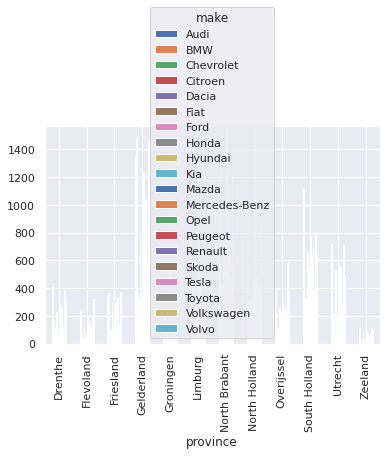

In [8]:
crosstab(df)

In [ ]:
df

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,warranty_months,engine_size,upholstery_colour,doors,upholstery,Entertainment & Media,Comfort & Convenience,Safety,extras,general_inspection
0,North Brabant,Audi,A3,Audi_A3,4450,Compact,2003,19,191066,Automatic,...,6,1984,Black,3,Cloth,"CD player, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Alarm system', 'Central door lock', ...",Alloy wheels,True
1,Limburg,Audi,A3,Audi_A3,12950,Compact,2013,9,94758,Automatic,...,0,1395,Black,5,Cloth,"CD player, Radio","Air conditioning, Automatic climate control, E...","[['Alarm system', 'Central door lock', 'Centra...",Alloy wheels,False
2,North Brabant,Audi,A3,Audi_A3,12445,Compact,2013,9,160883,Automatic,...,0,1395,Black,5,Cloth,"Bluetooth, CD player, Hands-free equipment, MP...","Air conditioning, Armrest, Cruise control, Ele...","[['ABS', 'Central door lock', 'Central door lo...","Alloy wheels,Spoiler",False
3,North Brabant,Audi,A1,Audi_A1,12450,Compact,2015,7,145102,Automatic,...,6,1395,Black,5,Part leather,"Bluetooth, CD player, On-board computer, USB","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Central door lock with remote contro...",Alloy wheels,True
4,Gelderland,Audi,A1,Audi_A1,14945,Compact,2015,7,119666,Automatic,...,6,1395,Black,3,Part leather,"CD player, MP3, On-board computer, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Alarm system', 'Bi-Xenon headlights'...","Alloy wheels,Shift paddles,Sport seats,Sport s...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,South Holland,Volvo,S60,Volvo_S60,1999,Sedan,2005,17,442713,Manual,...,0,2435,Beige,4,Part leather,"CD player, On-board computer, Radio","Air conditioning, Automatic climate control, C...","[['ABS', 'Central door lock', 'Central door lo...",Alloy wheels,True
69507,Friesland,Volvo,S60,Volvo_S60,3950,Sedan,2005,17,251723,Manual,...,0,2435,Beige,4,Full leather,Radio,"Air conditioning, Automatic climate control, C...","[['ABS', 'Alarm system', 'Central door lock', ...",Alloy wheels,True
69508,Flevoland,Volvo,S60,Volvo_S60,3449,Sedan,2004,18,340257,Manual,...,0,1984,Beige,4,Part leather,On-board computer,"Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Central door lock', 'Central door lo...","Alloy wheels,Automatically dimming interior mi...",True
69509,North Holland,Volvo,S40,Volvo_S40,1650,Sedan,2004,18,399990,Manual,...,0,2435,Beige,4,Velour,"CD player, On-board computer, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Central door lock with remote contro...","Alloy wheels,Automatically dimming interior mi...",False


## Registration

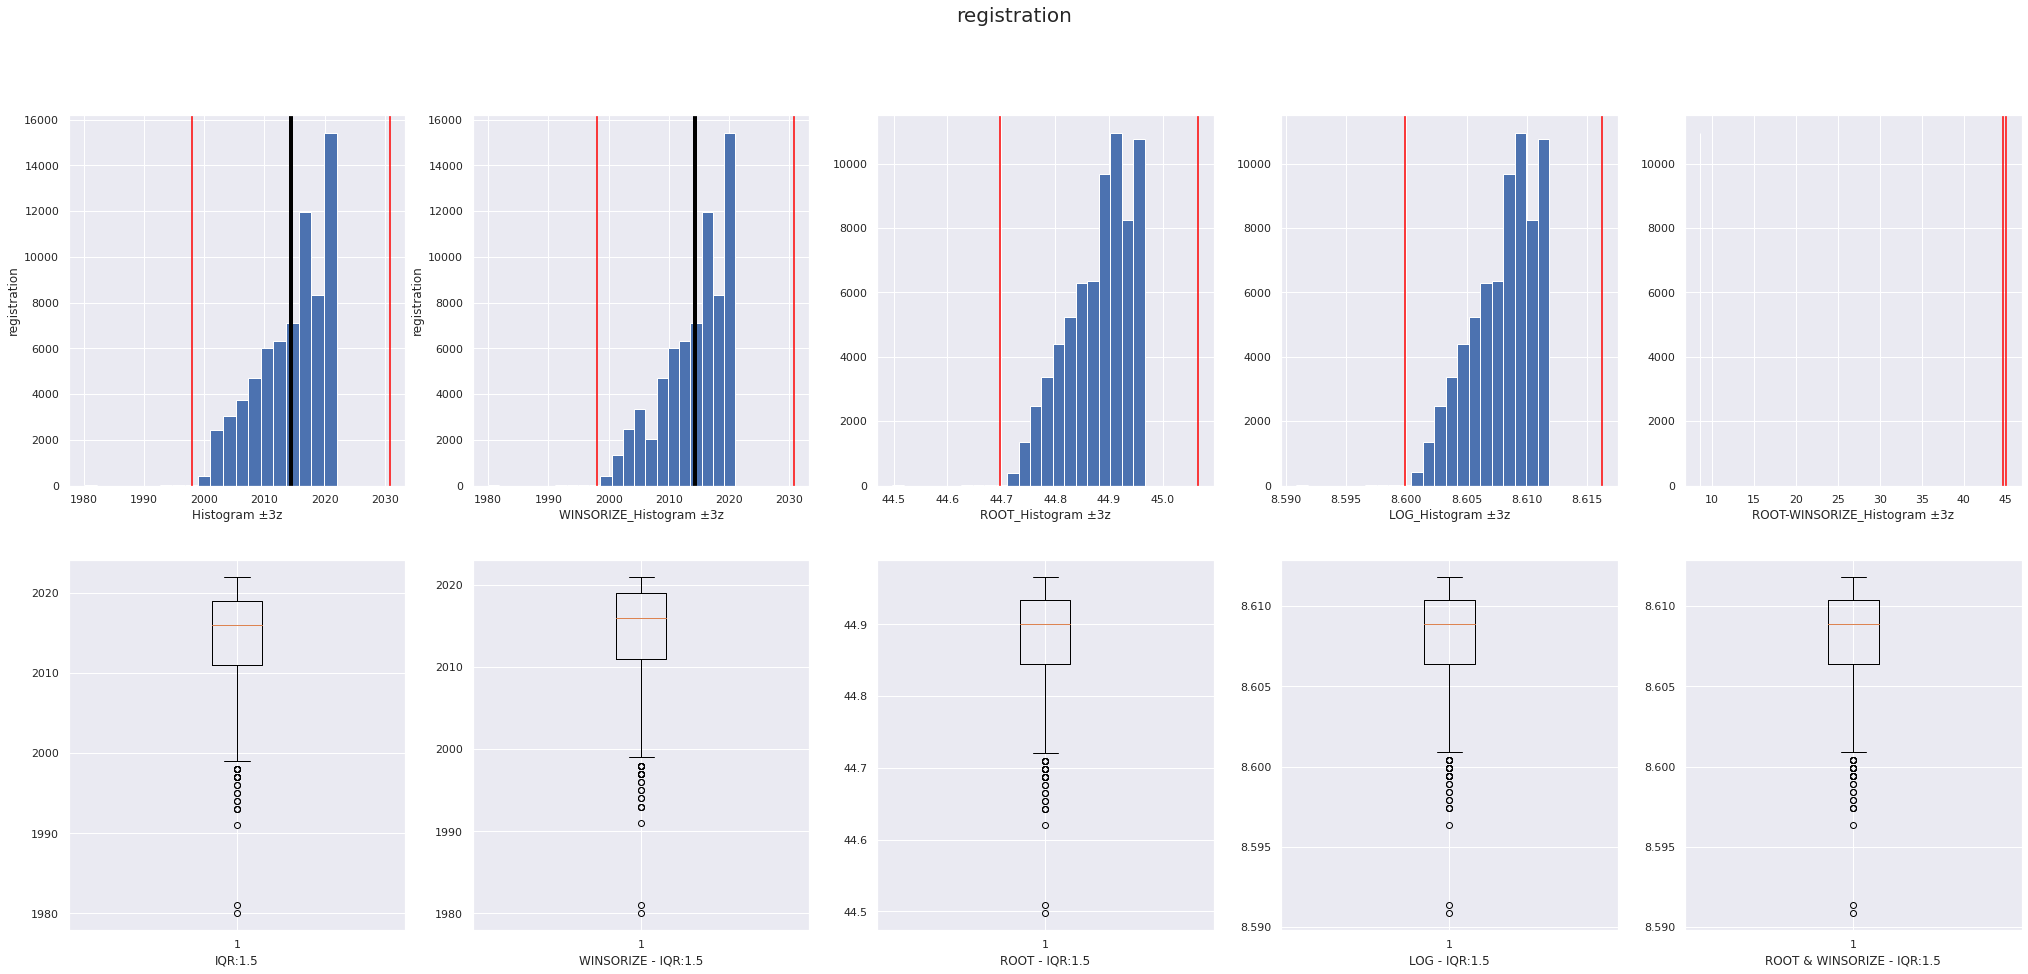

In [ ]:
col_plot(df,'registration')

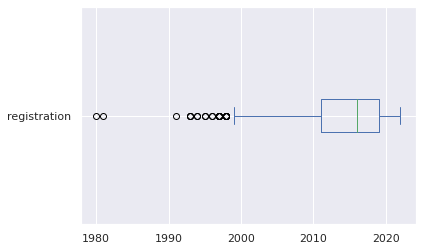

In [ ]:
df.registration.plot.box(vert=False);

In [ ]:
outliers(df.registration)

,count,values
0,IQR,8.000000
1,Lower Bound,1999.000000
2,Q1,2011.000000
3,Q2,2016.000000
4,Q3,2019.000000
5,Upper Bound,2022.000000
6,Count of Outliers,24.000000
7,Percentage of Outliers,0.000345


In [ ]:
df.registration.describe()

count    69511.000000
mean      2014.405878
std          5.495591
min       1980.000000
25%       2011.000000
50%       2016.000000
75%       2019.000000
max       2022.000000
Name: registration, dtype: float64

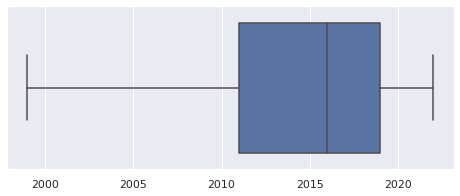

0        2003.0
1        2013.0
2        2013.0
3        2015.0
4        2015.0
          ...  
69506    2005.0
69507    2005.0
69508    2004.0
69509    2004.0
69510    2001.0
Name: registration, Length: 69511, dtype: float64

In [ ]:
capping_outliers(df.registration)

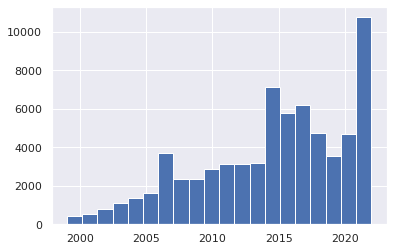

In [ ]:
df.registration.hist(bins=20)

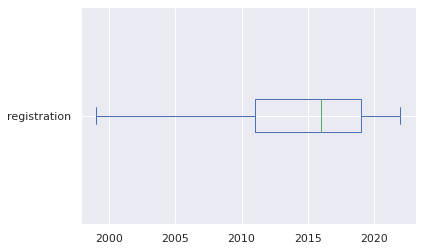

In [ ]:
df.registration.plot.box(vert=False);

In [ ]:
outliers(df.registration)

,count,values
0,IQR,8.0
1,Lower Bound,1999.0
2,Q1,2011.0
3,Q2,2016.0
4,Q3,2019.0
5,Upper Bound,2022.0
6,Count of Outliers,0.0
7,Percentage of Outliers,0.0


In [ ]:
df.registration.describe()

count    69511.000000
mean      2014.407389
std          5.490062
min       1999.000000
25%       2011.000000
50%       2016.000000
75%       2019.000000
max       2022.000000
Name: registration, dtype: float64

## Vehicle_age

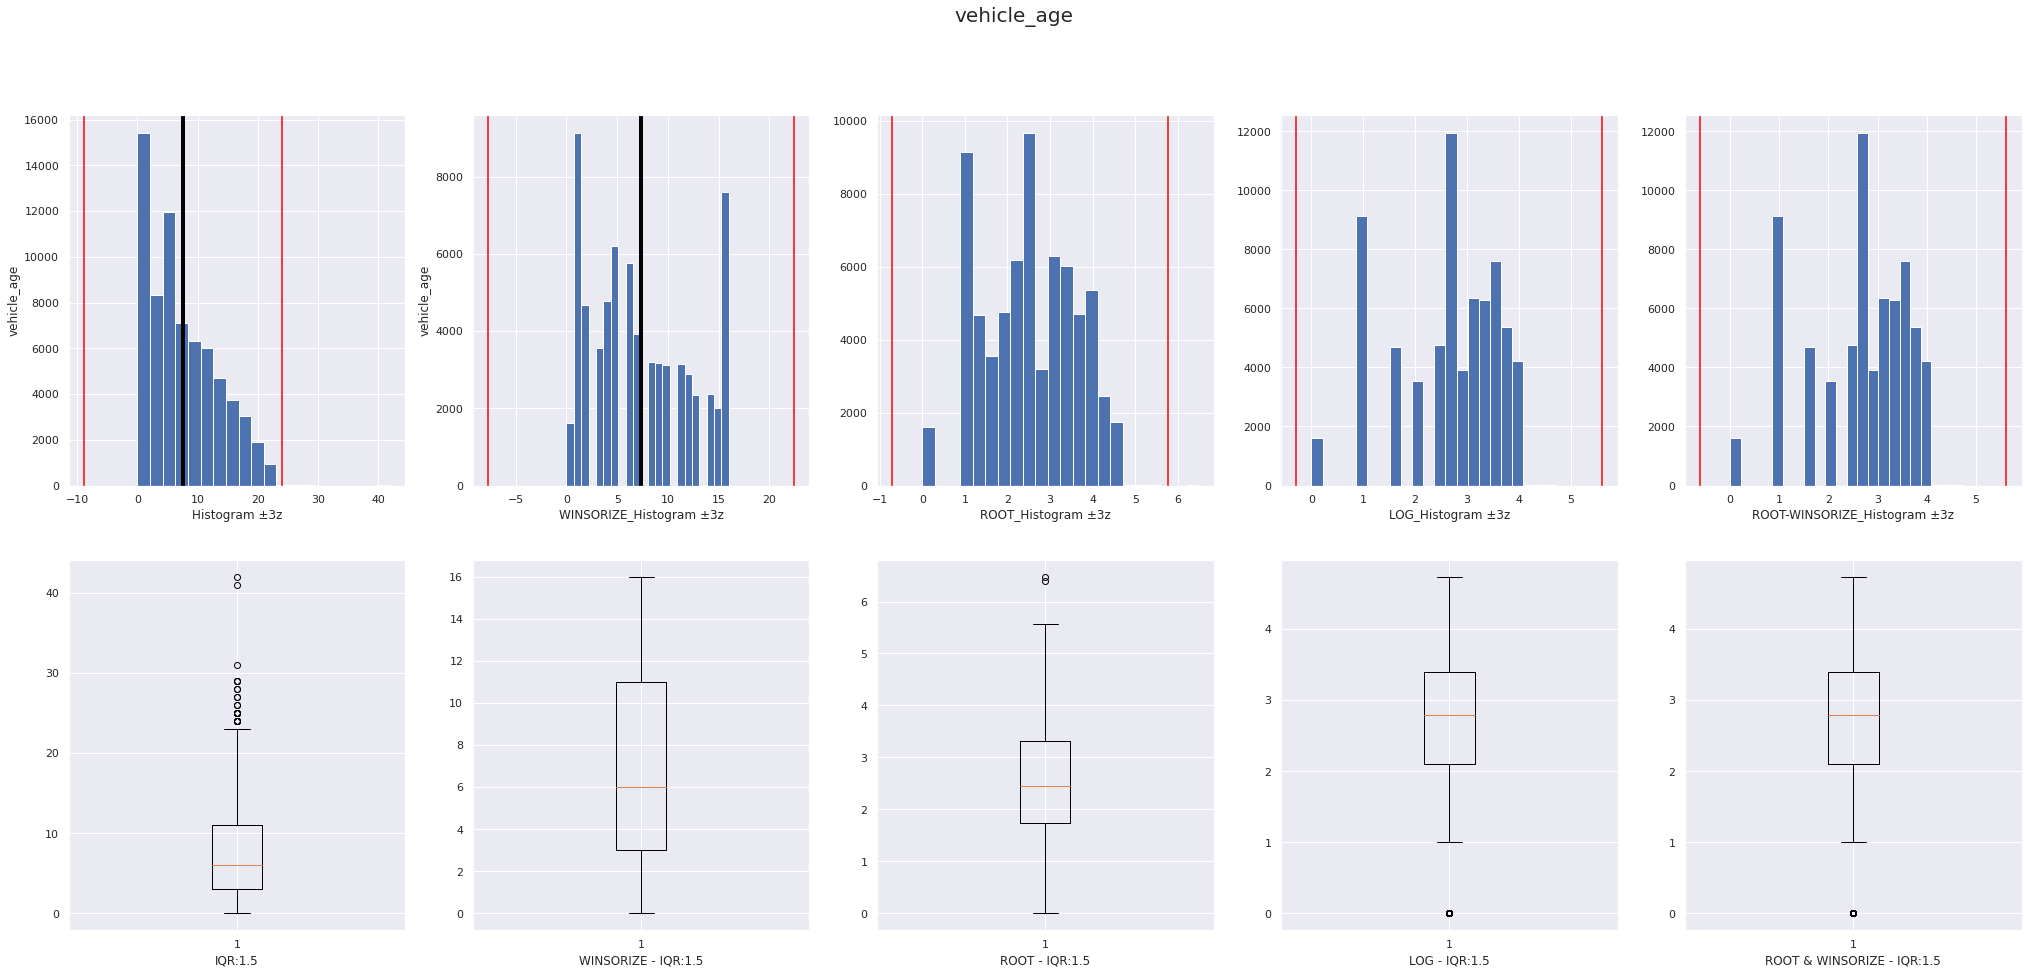

In [ ]:
col_plot(df,'vehicle_age')

In [ ]:
outliers(df.vehicle_age)

,count,values
0,IQR,8.000000
1,Lower Bound,0.000000
2,Q1,3.000000
3,Q2,6.000000
4,Q3,11.000000
5,Upper Bound,23.000000
6,Count of Outliers,24.000000
7,Percentage of Outliers,0.000345


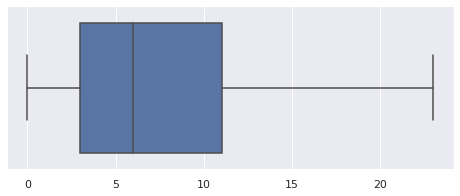

0        19.0
1         9.0
2         9.0
3         7.0
4         7.0
         ... 
69506    17.0
69507    17.0
69508    18.0
69509    18.0
69510    21.0
Name: vehicle_age, Length: 69511, dtype: float64

In [ ]:
capping_outliers(df.vehicle_age)

## empty_weight

In [ ]:
df.empty_weight.describe()

count    69511.000000
mean      1434.794953
std        322.011597
min        690.000000
25%       1234.000000
50%       1383.000000
75%       1595.000000
max       4200.000000
Name: empty_weight, dtype: float64

In [ ]:
outliers(df.empty_weight)

,count,values
0,IQR,361.000000
1,Lower Bound,692.500000
2,Q1,1234.000000
3,Q2,1383.000000
4,Q3,1595.000000
5,Upper Bound,2136.500000
6,Count of Outliers,2739.000000
7,Percentage of Outliers,0.039404


In [ ]:
df[df.empty_weight>2136]

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,warranty_months,engine_size,upholstery_colour,doors,upholstery,Entertainment & Media,Comfort & Convenience,Safety,extras,general_inspection
1499,Gelderland,Audi,Q7,Audi_Q7,16950,Off-Road/Pick-up,2006.0,16.0,218798,Automatic,...,0,4163,Black,5,Full leather,"CD player, On-board computer, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Alarm system', 'Bi-Xenon headlights'...","Alloy wheels,Automatically dimming interior mi...",False
1533,Gelderland,Audi,Q7,Audi_Q7,25950,Off-Road/Pick-up,2010.0,12.0,168367,Automatic,...,0,2995,Black,5,Part leather,"On-board computer, Radio","Air conditioning, Automatic climate control, C...","[['ABS', 'Adaptive Cruise Control', 'Adaptive ...","Alloy wheels,Headlight washer system,Roof rack...",False
1613,North Holland,Audi,Q7,Audi_Q7,24995,Off-Road/Pick-up,2011.0,11.0,179847,Automatic,...,0,2995,Black,5,Part leather,"On-board computer, Radio","Air conditioning, Automatic climate control, C...","[['ABS', 'Adaptive Cruise Control', 'Adaptive ...","Alloy wheels,Headlight washer system,Roof rack...",True
1659,North Brabant,Audi,Q7,Audi_Q7,16900,Off-Road/Pick-up,2007.0,15.0,178074,Automatic,...,0,3597,Black,5,Cloth,"CD player, On-board computer, Radio","Air conditioning, Automatic climate control, C...","[['ABS', 'Bi-Xenon headlights', 'Central door ...","Alloy wheels,Roof rack",True
1661,North Brabant,Audi,Q7,Audi_Q7,16750,Off-Road/Pick-up,2006.0,16.0,211329,Automatic,...,0,4163,Grey,5,Part leather,"On-board computer, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Adaptive headlights', 'Alarm system'...","Automatically dimming interior mirror,Headligh...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68881,Gelderland,Volvo,XC90,Volvo_XC90,49995,Off-Road/Pick-up,2015.0,7.0,118499,Automatic,...,0,1969,Beige,5,Full leather,"Apple CarPlay, Digital cockpit, On-board compu...","Air conditioning, Air suspension, Armrest, Aut...","[['ABS', 'Adaptive Cruise Control', 'Adaptive ...","Automatically dimming interior mirror,Roof rac...",True
69313,Groningen,Volvo,XC90,Volvo_XC90,65900,Other,2018.0,4.0,84431,Automatic,...,0,1969,Brown,5,Full leather,"Android Auto, Apple CarPlay, Digital cockpit, ...","Air conditioning, Air suspension, Armrest, Aut...","[['ABS', 'Adaptive Cruise Control', 'Adaptive ...","Alloy wheels,Automatically dimming interior mi...",True
69321,Limburg,Volvo,XC90,Volvo_XC90,36595,Van,2016.0,6.0,137147,Automatic,...,6,1969,Brown,5,Full leather,"Bluetooth, MP3, On-board computer, USB","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Adaptive Cruise Control', 'Alarm sys...","Alloy wheels,Automatically dimming interior mi...",True
69437,South Holland,Volvo,XC90,Volvo_XC90,6999,Off-Road/Pick-up,2004.0,18.0,369550,Automatic,...,0,2922,Black,5,Full leather,"CD player, On-board computer, Radio","Air conditioning, Armrest, Automatic climate c...","[['ABS', 'Alarm system', 'Bi-Xenon headlights'...","Alloy wheels,Automatically dimming interior mi...",False


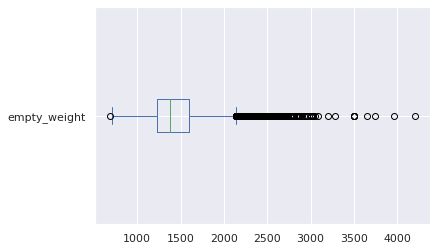

In [ ]:
df.empty_weight.plot.box(vert=False);

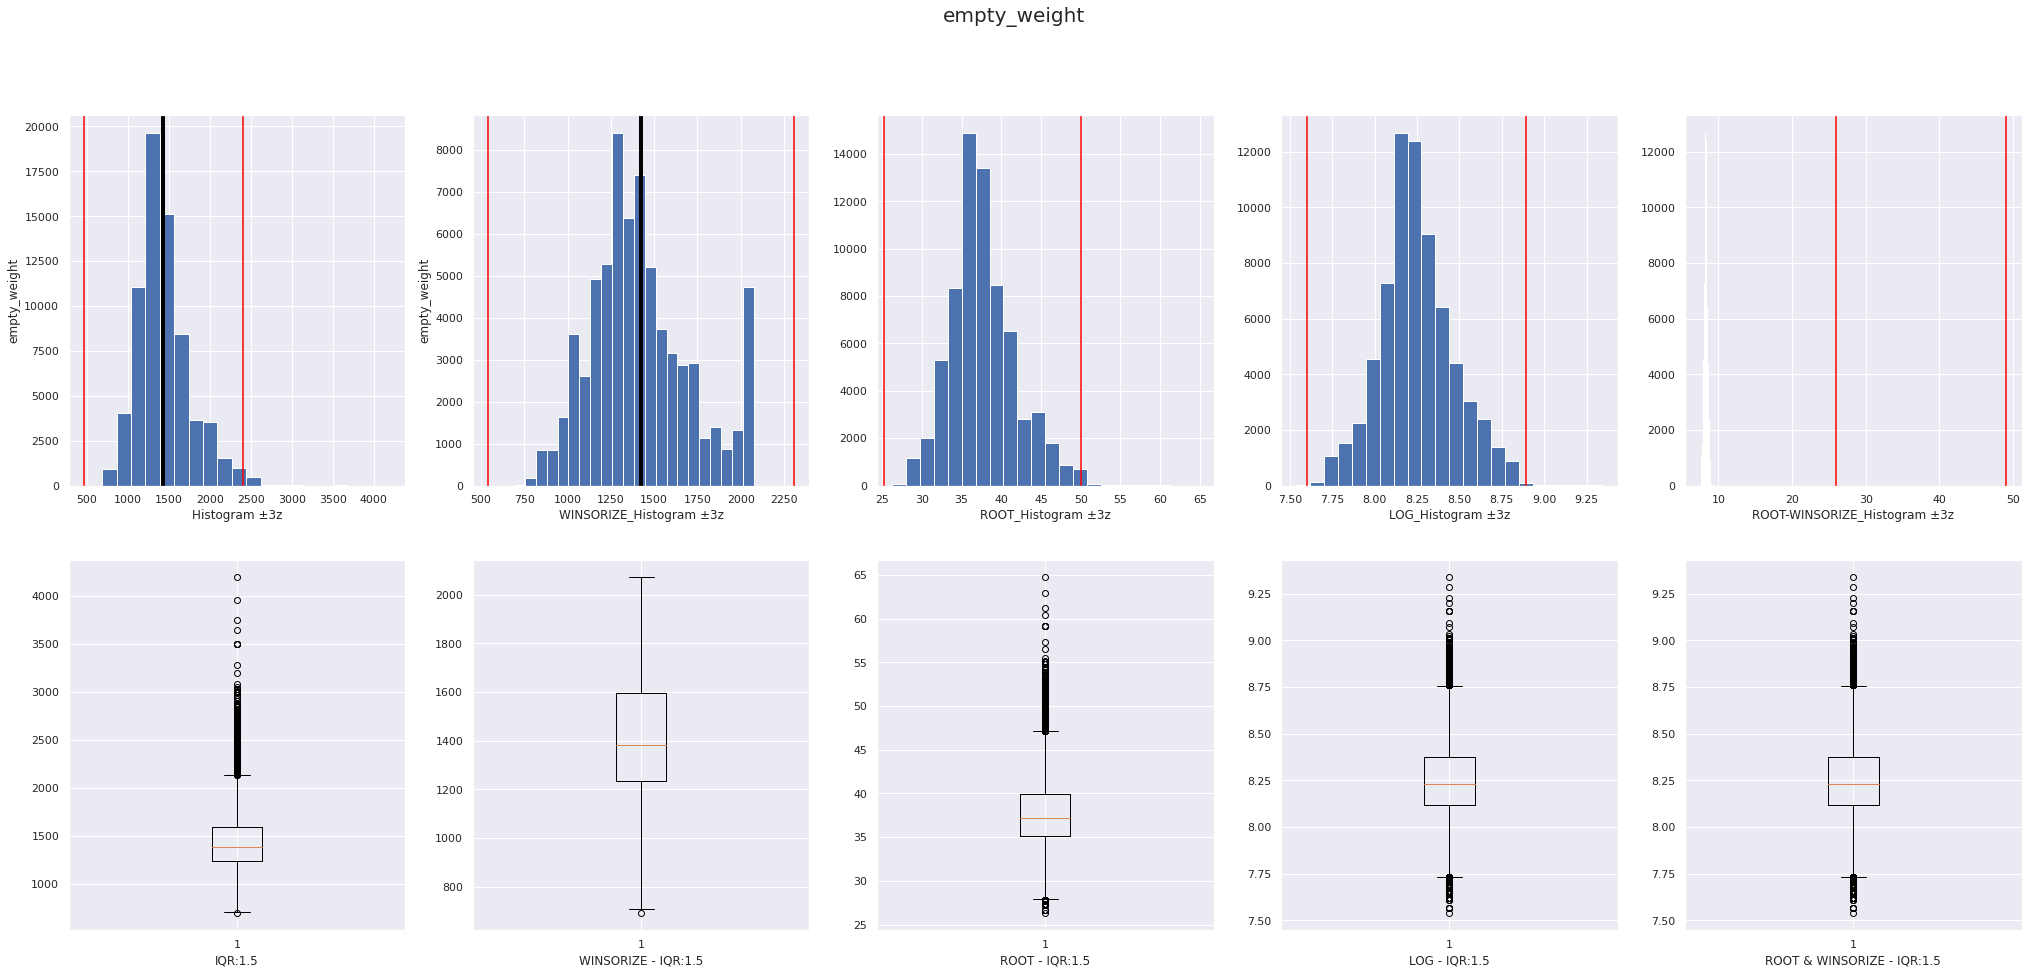

In [ ]:
col_plot(df.dropna(), "empty_weight", up=0.05)

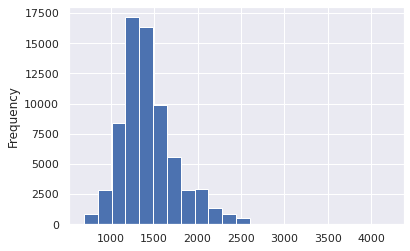

In [ ]:
winsor = winsorize(df.empty_weight.dropna())
pd.Series(winsor).plot.hist(bins = 22);

In [ ]:
outliers(df.empty_weight)

,count,values
0,IQR,361.000000
1,Lower Bound,692.500000
2,Q1,1234.000000
3,Q2,1383.000000
4,Q3,1595.000000
5,Upper Bound,2136.500000
6,Count of Outliers,2739.000000
7,Percentage of Outliers,0.039404


In [ ]:
bins = [0,1000,1400,1800,2200,5000]
group_names = ['very_light','light','normal','heavy','very_heavy']
df.empty_weight = pd.cut(df.empty_weight,bins,labels=group_names)
df.empty_weight

0         light
1         light
2         light
3         light
4         light
          ...  
69506    normal
69507    normal
69508    normal
69509     light
69510    normal
Name: empty_weight, Length: 69511, dtype: category
Categories (5, object): ['very_light' < 'light' < 'normal' < 'heavy' < 'very_heavy']

In [ ]:
df.empty_weight.value_counts()

light         33748
normal        23610
heavy          6719
very_light     3453
very_heavy     1981
Name: empty_weight, dtype: int64

## province

In [ ]:
#crosstab(df)

## Encoding

### one hot

In [ ]:
dummys = df['Entertainment & Media'].str.replace('([^\w]\s)',',').str.get_dummies(sep = ",")
for i in dummys : 
  print(dummys[f'{i}'].value_counts(dropna=False,normalize=True))

0    0.782509
1    0.217491
Name: Android Auto, dtype: float64
0    0.776812
1    0.223188
Name: Apple CarPlay, dtype: float64
0    0.86313
1    0.13687
Name: Bluetooth, dtype: float64
0    0.522464
1    0.477536
Name: CD player, dtype: float64
0    0.85703
1    0.14297
Name: Digital cockpit, dtype: float64
0    0.693545
1    0.306455
Name: Digital radio, dtype: float64
0    0.822676
1    0.177324
Name: Hands-free equipment, dtype: float64
0    0.895945
1    0.104055
Name: Induction charging for smartphones, dtype: float64
0    0.987743
1    0.012257
Name: Integrated music streaming, dtype: float64
0    0.727309
1    0.272691
Name: MP3, dtype: float64
1    0.675447
0    0.324553
Name: On-board computer, dtype: float64
1    0.881501
0    0.118499
Name: Radio, dtype: float64
0    0.939592
1    0.060408
Name: Sound system, dtype: float64
0    0.996893
1    0.003107
Name: Television, dtype: float64
0    0.917581
1    0.082419
Name: USB, dtype: float64
0    0.986491
1    0.013509
Name: WLAN

In [ ]:
df = pd.concat([df,dummys],axis = 1)

In [ ]:
df.drop('Entertainment & Media',axis = 1 , inplace = True)

In [ ]:
df

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,Induction charging for smartphones,Integrated music streaming,MP3,On-board computer,Radio,Sound system,Television,USB,WLAN,WiFi hotspot
0,North Brabant,Audi,A3,Audi_A3,4450,Compact,2003.0,19.0,191066,Automatic,...,0,0,0,0,1,0,0,0,0,0
1,Limburg,Audi,A3,Audi_A3,12950,Compact,2013.0,9.0,94758,Automatic,...,0,0,0,0,1,0,0,0,0,0
2,North Brabant,Audi,A3,Audi_A3,12445,Compact,2013.0,9.0,160883,Automatic,...,0,0,1,1,1,0,0,0,0,0
3,North Brabant,Audi,A1,Audi_A1,12450,Compact,2015.0,7.0,145102,Automatic,...,0,0,0,1,0,0,0,1,0,0
4,Gelderland,Audi,A1,Audi_A1,14945,Compact,2015.0,7.0,119666,Automatic,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,South Holland,Volvo,S60,Volvo_S60,1999,Sedan,2005.0,17.0,442713,Manual,...,0,0,0,1,1,0,0,0,0,0
69507,Friesland,Volvo,S60,Volvo_S60,3950,Sedan,2005.0,17.0,251723,Manual,...,0,0,0,0,1,0,0,0,0,0
69508,Flevoland,Volvo,S60,Volvo_S60,3449,Sedan,2004.0,18.0,340257,Manual,...,0,0,0,1,0,0,0,0,0,0
69509,North Holland,Volvo,S40,Volvo_S40,1650,Sedan,2004.0,18.0,399990,Manual,...,0,0,0,1,1,0,0,0,0,0


# Muhammed

## 1 mileage

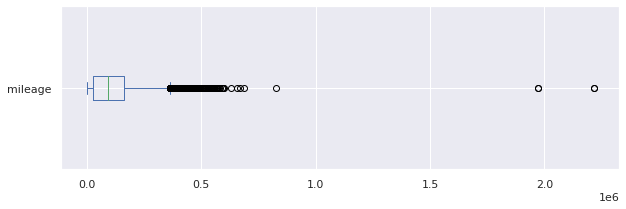

In [ ]:
df.mileage.plot.box(figsize=(10,3), vert=False);

In [ ]:
outliers(df.mileage)

,count,values
0,IQR,133633.000000
1,Lower Bound,1.000000
2,Q1,29531.000000
3,Q2,94901.000000
4,Q3,163164.000000
5,Upper Bound,363613.500000
6,Count of Outliers,564.000000
7,Percentage of Outliers,0.008114


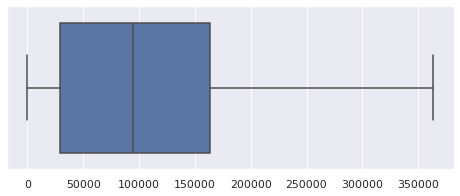

In [ ]:
df.mileage = capping_outliers(df.mileage)

In [ ]:
outliers(df.mileage)

,count,values
0,IQR,133633.0
1,Lower Bound,1.0
2,Q1,29531.0
3,Q2,94901.0
4,Q3,163164.0
5,Upper Bound,363613.5
6,Count of Outliers,0.0
7,Percentage of Outliers,0.0


## 2 co2_emissions

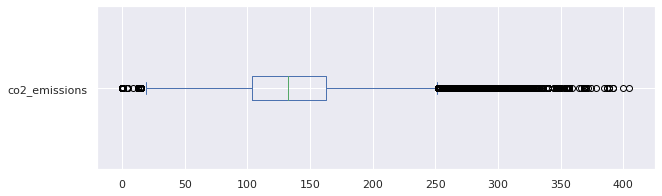

In [ ]:
df.co2_emissions.plot.box(figsize=(10,3), vert=False);

In [ ]:
outliers(df.co2_emissions)

,count,values
0,IQR,59.000000
1,Lower Bound,15.500000
2,Q1,104.000000
3,Q2,132.000000
4,Q3,163.000000
5,Upper Bound,251.500000
6,Count of Outliers,7252.000000
7,Percentage of Outliers,0.104329


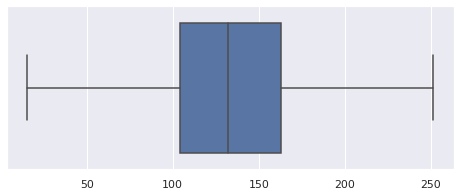

In [ ]:
df.co2_emissions = capping_outliers(df.co2_emissions)

In [ ]:
outliers(df.co2_emissions)

,count,values
0,IQR,59.0
1,Lower Bound,15.5
2,Q1,104.0
3,Q2,132.0
4,Q3,163.0
5,Upper Bound,251.5
6,Count of Outliers,0.0
7,Percentage of Outliers,0.0


## 6 colour

In [ ]:
df["colour"].value_counts(dropna=False, normalize=True)

Grey      0.334595
Black     0.257628
White     0.146480
Blue      0.126656
Red       0.046280
Brown     0.027377
Silver    0.026614
Green     0.012717
Beige     0.008186
Orange    0.005337
Yellow    0.004330
Violet    0.002446
Gold      0.000834
Bronze    0.000518
Name: colour, dtype: float64

In [ ]:
df.colour.replace(["Brown", "Silver", "Green","Other","Beige", "Orange","Yellow","Violet","Gold", "Bronze" ], ["Others", "Others", "Others","Others","Others", "Others","Others","Others","Others", "Others"], inplace= True)

In [ ]:
df["colour"].value_counts(dropna=False, normalize=True)

Grey      0.334595
Black     0.257628
White     0.146480
Blue      0.126656
Others    0.088360
Red       0.046280
Name: colour, dtype: float64

## 7 upholstery

In [ ]:
df["upholstery"].value_counts()

Cloth           32643
Full leather    21843
Part leather    12307
alcantara        1403
Other             689
Velour            626
Name: upholstery, dtype: int64

In [ ]:
df["upholstery"].value_counts(dropna=False, normalize=True)

Cloth           0.469609
Full leather    0.314238
Part leather    0.177051
alcantara       0.020184
Other           0.009912
Velour          0.009006
Name: upholstery, dtype: float64

In [ ]:
df.upholstery.replace(["Velour", "alcantara", "Part leather", "Full leather" ], ["Cloth", "Part\Full leather", "Part\Full leather", "Part\Full leather"], inplace= True)

In [ ]:
df["upholstery"].value_counts(dropna=False, normalize=True)

Part\Full leather    0.511473
Cloth                0.478615
Other                0.009912
Name: upholstery, dtype: float64

## 8 combination(L/100Km)

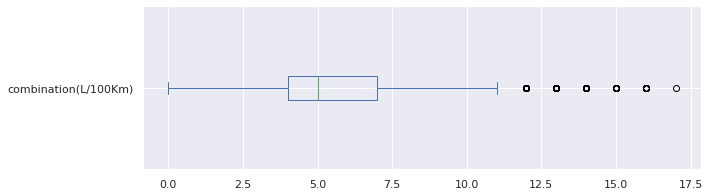

In [ ]:
df['combination(L/100Km)'].plot.box(figsize=(10,3), vert=False);

In [ ]:
outliers(df['combination(L/100Km)'])

,count,values
0,IQR,3.000000
1,Lower Bound,0.000000
2,Q1,4.000000
3,Q2,5.000000
4,Q3,7.000000
5,Upper Bound,11.500000
6,Count of Outliers,816.000000
7,Percentage of Outliers,0.011739


In [ ]:
# df['combination(L/100Km)'] = capping_outliers(df['combination(L/100Km)'])

In [ ]:
outliers(df['combination(L/100Km)'])

,count,values
0,IQR,3.000000
1,Lower Bound,0.000000
2,Q1,4.000000
3,Q2,5.000000
4,Q3,7.000000
5,Upper Bound,11.500000
6,Count of Outliers,816.000000
7,Percentage of Outliers,0.011739


## 9 city(L/100Km)

In [ ]:
outliers(df['city(L/100Km)'])

,count,values
0,IQR,4.000000
1,Lower Bound,0.000000
2,Q1,5.000000
3,Q2,7.000000
4,Q3,9.000000
5,Upper Bound,15.000000
6,Count of Outliers,927.000000
7,Percentage of Outliers,0.013336


In [ ]:
# df['city(L/100Km)'] = capping_outliers(df['city(L/100Km)'])

In [ ]:
outliers(df['city(L/100Km)'])

,count,values
0,IQR,4.000000
1,Lower Bound,0.000000
2,Q1,5.000000
3,Q2,7.000000
4,Q3,9.000000
5,Upper Bound,15.000000
6,Count of Outliers,927.000000
7,Percentage of Outliers,0.013336


# 10 country(L/100Km)

In [ ]:
outliers(df['country(L/100Km)'])

,count,values
0,IQR,1.000000
1,Lower Bound,2.500000
2,Q1,4.000000
3,Q2,5.000000
4,Q3,5.000000
5,Upper Bound,6.500000
6,Count of Outliers,10657.000000
7,Percentage of Outliers,0.153314


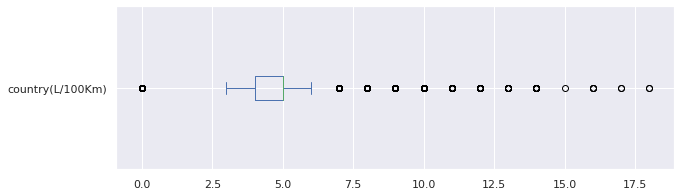

In [ ]:
df['country(L/100Km)'].plot.box(figsize=(10,3), vert=False);

In [ ]:
# df['country(L/100Km)'] = capping_outliers(df['country(L/100Km)'])

In [ ]:
outliers(df['country(L/100Km)'])

,count,values
0,IQR,1.000000
1,Lower Bound,2.500000
2,Q1,4.000000
3,Q2,5.000000
4,Q3,5.000000
5,Upper Bound,6.500000
6,Count of Outliers,10657.000000
7,Percentage of Outliers,0.153314


In [ ]:
df["extras"]

0                                             Alloy wheels
1                                             Alloy wheels
2                                     Alloy wheels,Spoiler
3                                             Alloy wheels
4        Alloy wheels,Shift paddles,Sport seats,Sport s...
                               ...                        
69506                                         Alloy wheels
69507                                         Alloy wheels
69508    Alloy wheels,Automatically dimming interior mi...
69509    Alloy wheels,Automatically dimming interior mi...
69510                                         Alloy wheels
Name: extras, Length: 69511, dtype: object

# 11extras

In [ ]:
dm=df['extras'].str.get_dummies(sep = ",")
dm

,All season tyres,Alloy wheels,Ambient lighting,Automatically dimming interior mirror,Awning,Biodiesel conversion,Cargo barrier,Catalytic Converter,E10-enabled,Electronic parking brake,...,Sport suspension,Steel wheels,Summer tyres,Touch screen,Trailer hitch,Tuned car,Voice Contro,Voice Control,Winter package,Winter tyres
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69507,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69508,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69509,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for i in dm : 
  print(dm[f'{i}'].value_counts(dropna=False,normalize=True))

0    0.989815
1    0.010185
Name: All season tyres, dtype: float64
1    0.85316
0    0.14684
Name: Alloy wheels, dtype: float64
0    0.963027
1    0.036973
Name: Ambient lighting, dtype: float64
1    0.514537
0    0.485463
Name: Automatically dimming interior mirror, dtype: float64
0    0.999842
1    0.000158
Name: Awning, dtype: float64
0    0.999439
1    0.000561
Name: Biodiesel conversion, dtype: float64
0    0.978449
1    0.021551
Name: Cargo barrier, dtype: float64
0    0.977356
1    0.022644
Name: Catalytic Converter, dtype: float64
0    0.995799
1    0.004201
Name: E10-enabled, dtype: float64
0    0.968854
1    0.031146
Name: Electronic parking brake, dtype: float64
0    0.985959
1    0.014041
Name: Emergency tyre, dtype: float64
0    0.955173
1    0.044827
Name: Emergency tyre repair kit, dtype: float64
0    0.997583
1    0.002417
Name: Handicapped enabled, dtype: float64
0    0.948612
1    0.051388
Name: Headlight washer system, dtype: float64
0    0.998662
1    0.001338
Name:

In [ ]:
dm['Voice control'] = dm['Voice Control'] + dm['Voice Contro'] 
dm.drop(['Voice Control','Voice Contro','Awning','Biodiesel conversion'],axis = 1 , inplace = True)

In [ ]:
df = pd.concat([df,dm],axis = 1)

In [ ]:
df.drop('extras',axis = 1 , inplace = True)

In [ ]:
dm

,All season tyres,Alloy wheels,Ambient lighting,Automatically dimming interior mirror,Cargo barrier,Catalytic Converter,E10-enabled,Electronic parking brake,Emergency tyre,Emergency tyre repair kit,...,Sport seats,Sport suspension,Steel wheels,Summer tyres,Touch screen,Trailer hitch,Tuned car,Winter package,Winter tyres,Voice control
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69507,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69508,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69509,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,Sport seats,Sport suspension,Steel wheels,Summer tyres,Touch screen,Trailer hitch,Tuned car,Winter package,Winter tyres,Voice control
0,North Brabant,Audi,A3,Audi_A3,4450,Compact,2003.0,19.0,191066.0,Automatic,...,0,0,0,0,0,0,0,0,0,0
1,Limburg,Audi,A3,Audi_A3,12950,Compact,2013.0,9.0,94758.0,Automatic,...,0,0,0,0,0,0,0,0,0,0
2,North Brabant,Audi,A3,Audi_A3,12445,Compact,2013.0,9.0,160883.0,Automatic,...,0,0,0,0,0,0,0,0,0,0
3,North Brabant,Audi,A1,Audi_A1,12450,Compact,2015.0,7.0,145102.0,Automatic,...,0,0,0,0,0,0,0,0,0,0
4,Gelderland,Audi,A1,Audi_A1,14945,Compact,2015.0,7.0,119666.0,Automatic,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,South Holland,Volvo,S60,Volvo_S60,1999,Sedan,2005.0,17.0,363613.5,Manual,...,0,0,0,0,0,0,0,0,0,0
69507,Friesland,Volvo,S60,Volvo_S60,3950,Sedan,2005.0,17.0,251723.0,Manual,...,0,0,0,0,0,0,0,0,0,0
69508,Flevoland,Volvo,S60,Volvo_S60,3449,Sedan,2004.0,18.0,340257.0,Manual,...,0,0,0,0,0,0,0,0,0,0
69509,North Holland,Volvo,S40,Volvo_S40,1650,Sedan,2004.0,18.0,363613.5,Manual,...,0,0,0,0,0,0,0,0,0,0


#Serkan

## power(kw)

In [ ]:
df['power(kW)'].describe()

count    69511.000000
mean       117.532031
std         55.090933
min         50.000000
25%         85.000000
50%        103.000000
75%        135.000000
max        620.000000
Name: power(kW), dtype: float64

In [ ]:
df['power(kW)'].quantile([0.25,0.5,0.75])

0.25     85.0
0.50    103.0
0.75    135.0
Name: power(kW), dtype: float64

In [ ]:
outliers(df['power(kW)'])

,count,values
0,IQR,50.00000
1,Lower Bound,50.00000
2,Q1,85.00000
3,Q2,103.00000
4,Q3,135.00000
5,Upper Bound,210.00000
6,Count of Outliers,4708.00000
7,Percentage of Outliers,0.06773


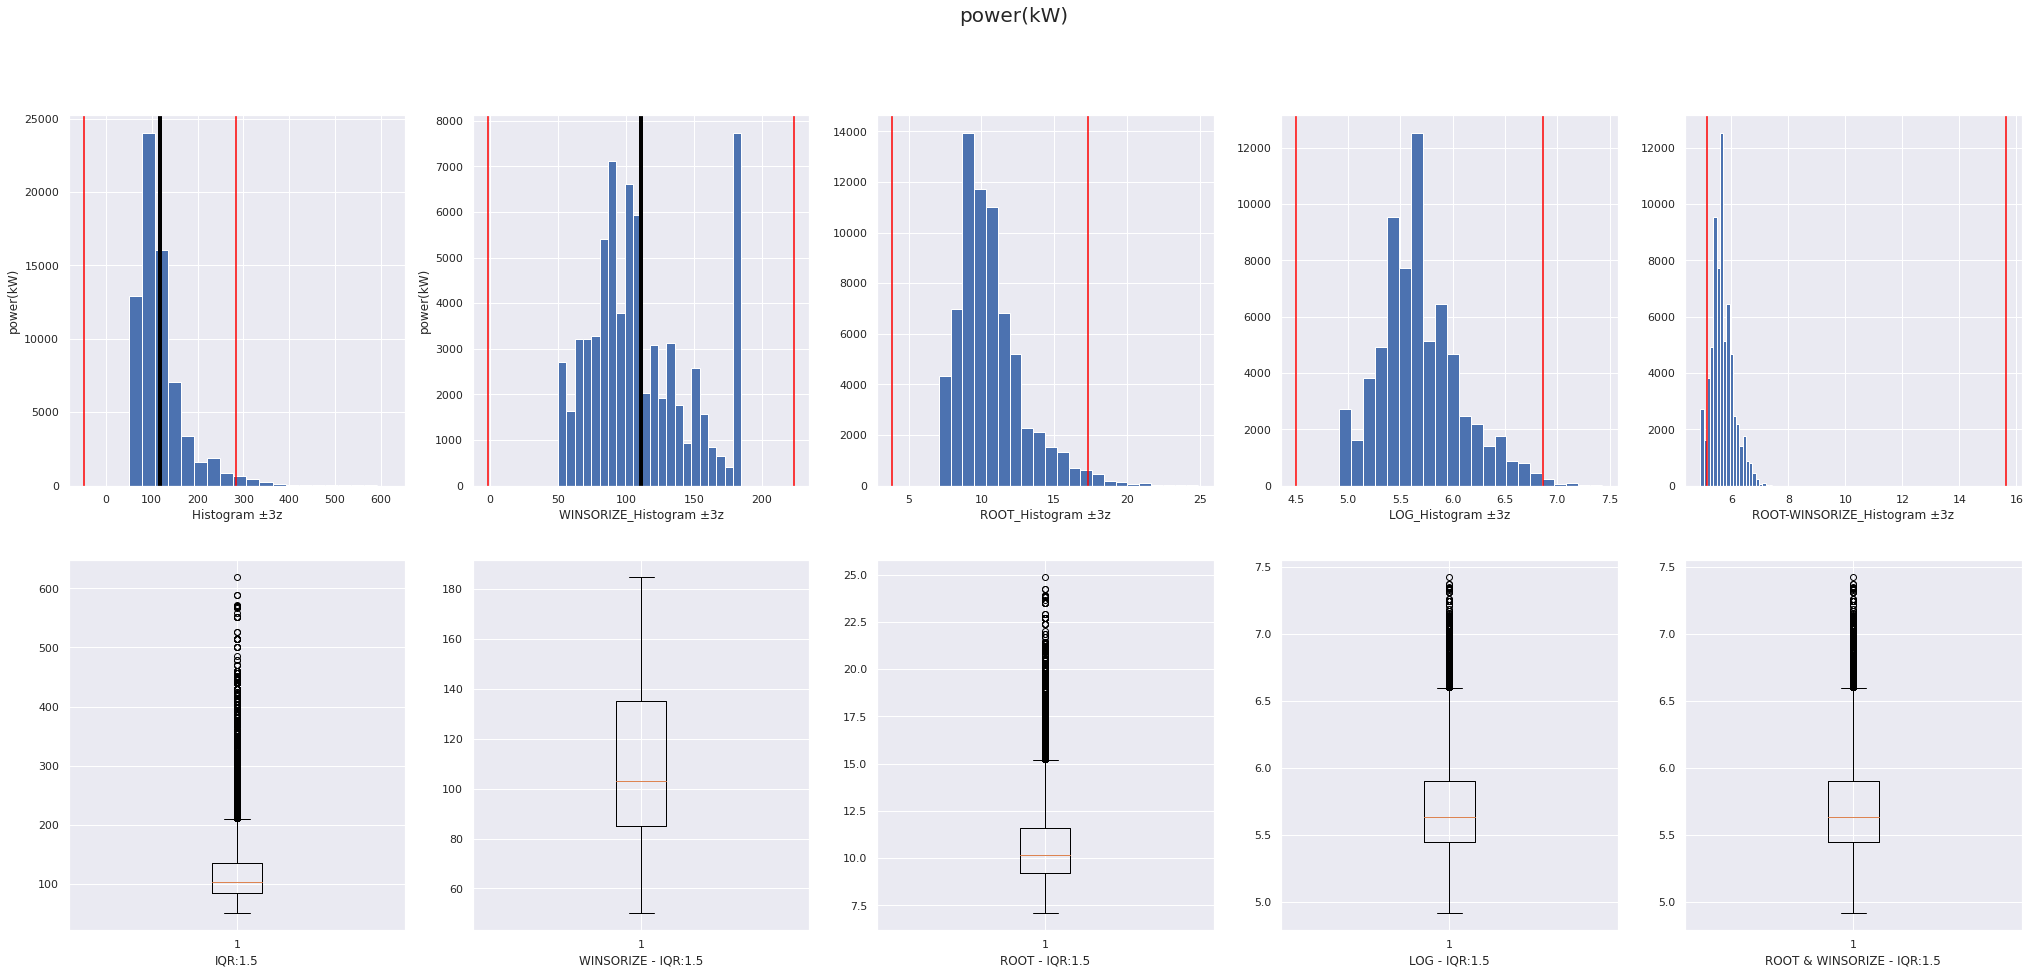

In [ ]:
col_plot(df,'power(kW)',up=0.1,down=0, iqr=1.5)

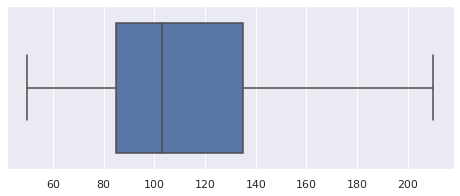

In [ ]:
df['power(kW)'] = capping_outliers(df['power(kW)'])

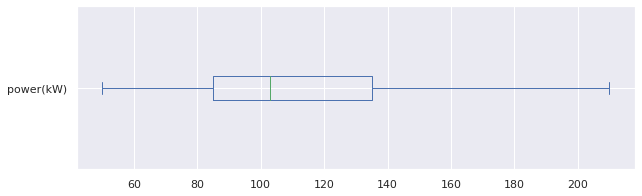

In [ ]:
df['power(kW)'].plot.box(figsize=(10,3), vert=False);

## Comfort & Convenience

In [ ]:
dd=df['Comfort & Convenience'].str.replace(r"([\['\]])",'')

dummies=dd.str.replace('([^\w]\s)',',').str.get_dummies(sep = ",")

In [ ]:
dummies.head()

,2 zones,3 zones,360,4 zones,Air conditioning,Air suspension,Armrest,Automatic climate contro,Automatic climate control,Auxiliary heating,...,Seat heating,Seat ventilation,Sliding door left,Sliding door right,Split rear seats,Start-stop system,Sunroof,Tinted windows,Wind deflector,camera
0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
dummies["Automatic Climate Control"]=dummies["Automatic climate control"]+dummies["Automatic climate contro"]

In [ ]:
dummies["Cruise Control"]=dummies["Cruise contro"]+dummies["Cruise control"]

In [ ]:
dummies["Leather Steering Wheel"]=dummies["Leather steering wheel"]+dummies["Leather steering whee"]

In [ ]:
dummies["Multi-function Steering Wheel"]=dummies["Multi-function steering whee"]+dummies["Multi-function steering wheel"]

In [ ]:
for i in dummies : 
  print(dummies[f'{i}'].value_counts(dropna=False,normalize=True))

0    0.985671
1    0.014329
Name: 2 zones, dtype: float64
0    0.995022
1    0.004978
Name: 3 zones, dtype: float64
0    0.993037
1    0.006963
Name: 360, dtype: float64
0    0.997598
1    0.002402
Name: 4 zones, dtype: float64
1    0.965214
0    0.034786
Name: Air conditioning, dtype: float64
0    0.960812
1    0.039188
Name: Air suspension, dtype: float64
1    0.706003
0    0.293997
Name: Armrest, dtype: float64
0    0.999942
1    0.000058
Name: Automatic climate contro, dtype: float64
1    0.771475
0    0.228525
Name: Automatic climate control, dtype: float64
0    0.941448
1    0.058552
Name: Auxiliary heating, dtype: float64
0    0.999741
1    0.000259
Name: Cruise contro, dtype: float64
1    0.858066
0    0.141934
Name: Cruise control, dtype: float64
0    0.98137
1    0.01863
Name: Electric backseat adjustment, dtype: float64
0    0.832055
1    0.167945
Name: Electric tailgate, dtype: float64
1    0.854239
0    0.145761
Name: Electrical side mirrors, dtype: float64
0    0.880163
1

In [ ]:
dummies.drop(['360','Automatic climate control','Automatic climate contro','Cruise control','Cruise contro','Leather steering whee','Leather steering wheel','Multi-function steering whee','Multi-function steering wheel'], axis=1, inplace=True)

In [ ]:
df = pd.concat([df,dummies],axis = 1)

In [ ]:
df.drop('Comfort & Convenience',axis = 1 , inplace = True)

# Efe

### Safety&Security -Dummy

In [ ]:
dd=df['Safety'].str.replace(r"([\['\]])",'')

In [ ]:
s_dummy=dd.str.replace('([^\w]\s)',',').str.get_dummies(sep = ",")

In [ ]:
s_dummy

,ABS,Adaptive Cruise Contro,Adaptive Cruise Control,Adaptive headlights,Alarm system,Bi-Xenon headlights,Blind spot monitor,Central door lock,Central door lock with remote contro,Central door lock with remote control,...,Passenger-side airbag,Power steering,Rear airbag,Side airbag,Speed limit control system,Tire pressure monitoring system,Traction contro,Traction control,Traffic sign recognition,Xenon headlights
0,1,0,0,0,1,0,0,1,0,1,...,1,1,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,1,1,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,1,1,0,0,0
4,1,0,0,0,1,1,0,1,0,1,...,1,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,1,0,0,0,0,0,0,1,0,1,...,1,1,0,1,0,0,1,0,0,0
69507,1,0,0,0,1,0,0,1,0,1,...,1,1,0,1,0,0,1,0,0,0
69508,1,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,0,0,0
69509,1,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0


In [ ]:
#Some features named mistakenly ,merge them and make new column,only this new column will remain ,afterwards drop used columns to avoid dublication
#after all,drop also "safety" -which already splitted in columns by "get_dummies"- permanently from df

In [ ]:
s_dummy["Adaptive Cruise Cntrl"]=s_dummy["Adaptive Cruise Contro"]+s_dummy["Adaptive Cruise Control"]

In [ ]:
s_dummy["Adaptive Cruise Cntrl"].value_counts()

0    56280
1    13231
Name: Adaptive Cruise Cntrl, dtype: int64

In [ ]:
s_dummy["Central door lock with remote control"].value_counts()

1    54969
0    14542
Name: Central door lock with remote control, dtype: int64

In [ ]:
s_dummy["Central door lock with remote contrl"]=s_dummy["Central door lock with remote control"]+s_dummy["Central door lock with remote contro"]

In [ ]:
s_dummy["Central door lock with remote contrl"].value_counts()

1    55010
0    14501
Name: Central door lock with remote contrl, dtype: int64

In [ ]:
s_dummy["Electronic stability contrl"]=s_dummy["Electronic stability control"]+s_dummy["Electronic stability contro"]

In [ ]:
s_dummy["Electronic stability contrl"].value_counts()

1    54767
0    14744
Name: Electronic stability contrl, dtype: int64

In [ ]:
s_dummy["Traction contrl"]=s_dummy["Traction contro"]+s_dummy["Traction control"]

In [ ]:
s_dummy["Traction contrl"].value_counts()

1    42529
0    26982
Name: Traction contrl, dtype: int64

In [ ]:
s_dummy.drop(s_dummy.columns[[1,2,8,9,14,15,37,36]], axis=1,inplace=True)

In [ ]:
df.drop(["Safety"],axis=1,inplace=True)

In [ ]:
df = pd.concat([df,s_dummy],axis = 1)

In [ ]:
df

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,Rear airbag,Side airbag,Speed limit control system,Tire pressure monitoring system,Traffic sign recognition,Xenon headlights,Adaptive Cruise Cntrl,Central door lock with remote contrl,Electronic stability contrl,Traction contrl
0,North Brabant,Audi,A3,Audi_A3,4450,Compact,2003.0,19.0,191066.0,Automatic,...,0,1,0,0,0,0,0,1,1,1
1,Limburg,Audi,A3,Audi_A3,12950,Compact,2013.0,9.0,94758.0,Automatic,...,0,0,0,0,0,0,0,1,0,0
2,North Brabant,Audi,A3,Audi_A3,12445,Compact,2013.0,9.0,160883.0,Automatic,...,0,1,0,0,0,0,0,1,1,1
3,North Brabant,Audi,A1,Audi_A1,12450,Compact,2015.0,7.0,145102.0,Automatic,...,0,1,0,1,0,0,0,1,1,1
4,Gelderland,Audi,A1,Audi_A1,14945,Compact,2015.0,7.0,119666.0,Automatic,...,0,1,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,South Holland,Volvo,S60,Volvo_S60,1999,Sedan,2005.0,17.0,363613.5,Manual,...,0,1,0,0,0,0,0,1,1,1
69507,Friesland,Volvo,S60,Volvo_S60,3950,Sedan,2005.0,17.0,251723.0,Manual,...,0,1,0,0,0,0,0,1,1,1
69508,Flevoland,Volvo,S60,Volvo_S60,3449,Sedan,2004.0,18.0,340257.0,Manual,...,0,1,0,0,0,0,0,1,0,1
69509,North Holland,Volvo,S40,Volvo_S40,1650,Sedan,2004.0,18.0,363613.5,Manual,...,0,1,0,0,0,0,0,1,0,0


# Engine size

In [ ]:
outliers(df.engine_size)

,count,values
0,IQR,598.000000
1,Lower Bound,647.000000
2,Q1,1395.000000
3,Q2,1598.000000
4,Q3,1993.000000
5,Upper Bound,2890.000000
6,Count of Outliers,5098.000000
7,Percentage of Outliers,0.073341


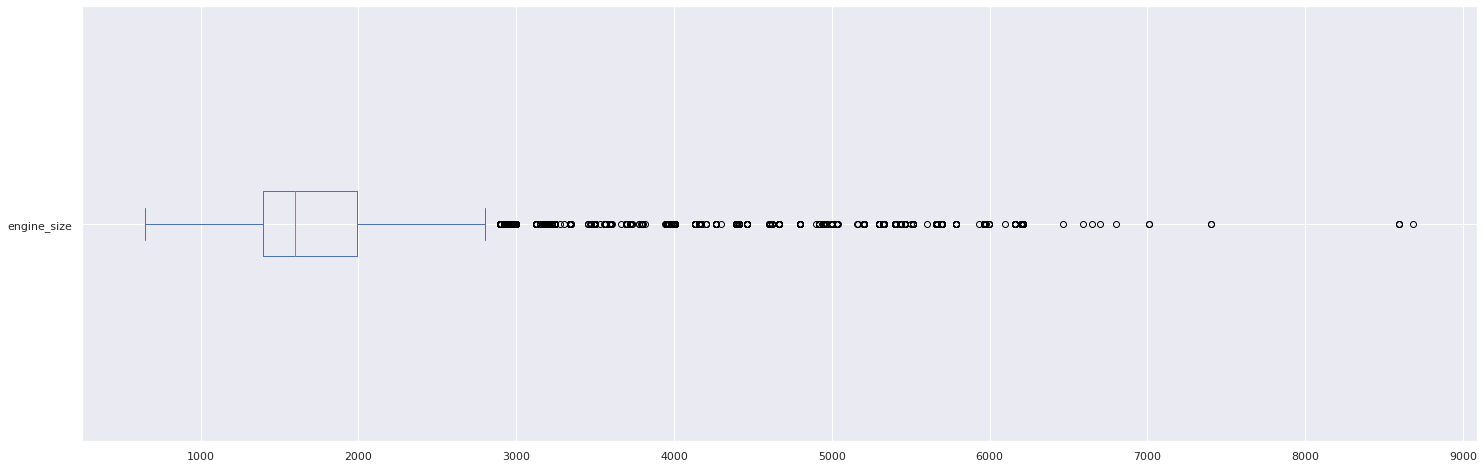

In [ ]:
df.engine_size.plot.box(figsize=(25, 8),vert=False)

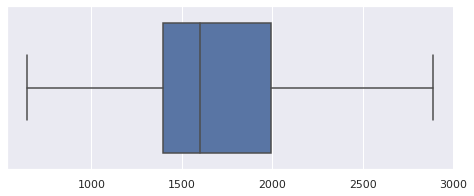

0        1984.0
1        1395.0
2        1395.0
3        1395.0
4        1395.0
          ...  
69506    2435.0
69507    2435.0
69508    1984.0
69509    2435.0
69510    2435.0
Name: engine_size, Length: 69511, dtype: float64

In [ ]:
capping_outliers(df.engine_size)

# Upholstery Colour

In [ ]:
#Reduce diversty; except top three colours, rest colours join "Other"

In [ ]:
df.upholstery_colour.replace(["Brown", "Blue", "White", "Red","Orange","Yellow","Green" ], ["Other","Other","Other","Other","Other","Other","Other"], inplace= True)

In [ ]:
df.upholstery_colour.value_counts(dropna=False,normalize=True)

Black    0.733265
Grey     0.144826
Other    0.082116
Beige    0.039792
Name: upholstery_colour, dtype: float64

In [ ]:
df

,province,make,model,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,...,Rear airbag,Side airbag,Speed limit control system,Tire pressure monitoring system,Traffic sign recognition,Xenon headlights,Adaptive Cruise Cntrl,Central door lock with remote contrl,Electronic stability contrl,Traction contrl
0,North Brabant,Audi,A3,Audi_A3,4450,Compact,2003.0,19.0,191066.0,Automatic,...,0,1,0,0,0,0,0,1,1,1
1,Limburg,Audi,A3,Audi_A3,12950,Compact,2013.0,9.0,94758.0,Automatic,...,0,0,0,0,0,0,0,1,0,0
2,North Brabant,Audi,A3,Audi_A3,12445,Compact,2013.0,9.0,160883.0,Automatic,...,0,1,0,0,0,0,0,1,1,1
3,North Brabant,Audi,A1,Audi_A1,12450,Compact,2015.0,7.0,145102.0,Automatic,...,0,1,0,1,0,0,0,1,1,1
4,Gelderland,Audi,A1,Audi_A1,14945,Compact,2015.0,7.0,119666.0,Automatic,...,0,1,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69506,South Holland,Volvo,S60,Volvo_S60,1999,Sedan,2005.0,17.0,363613.5,Manual,...,0,1,0,0,0,0,0,1,1,1
69507,Friesland,Volvo,S60,Volvo_S60,3950,Sedan,2005.0,17.0,251723.0,Manual,...,0,1,0,0,0,0,0,1,1,1
69508,Flevoland,Volvo,S60,Volvo_S60,3449,Sedan,2004.0,18.0,340257.0,Manual,...,0,1,0,0,0,0,0,1,0,1
69509,North Holland,Volvo,S40,Volvo_S40,1650,Sedan,2004.0,18.0,363613.5,Manual,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
# df.to_pickle('/content/drive/MyDrive/Colab Notebooks/defaultdataset.pickle')

In [ ]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)

In [ ]:
df.dtypes

province                                   object
make                                       object
model                                      object
make_model                                 object
price                                       int64
body_type                                  object
registration                              float64
vehicle_age                               float64
mileage                                   float64
Gearbox                                    object
gears                                       int64
seller                                     object
colour                                     object
power(kW)                                 float64
cylinders                                   int64
drivetrain                                 object
type                                       object
full_service_history                       object
fuel_type                                  object
combination(L/100Km)                        int64


In [ ]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_rows',50)

In [ ]:
df.drop(columns=['model'], axis=1, inplace=True)

## labelling

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:


for column in df.select_dtypes(exclude=[np.number]).columns:

 df[f'{column}'] = labelencoder.fit_transform(df[f'{column}'])

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
df.dtypes

province                                   int64
make                                       int64
make_model                                 int64
price                                      int64
body_type                                  int64
registration                             float64
vehicle_age                              float64
mileage                                  float64
Gearbox                                    int64
gears                                      int64
seller                                     int64
colour                                     int64
power(kW)                                float64
cylinders                                  int64
drivetrain                                 int64
type                                       int64
full_service_history                       int64
fuel_type                                  int64
combination(L/100Km)                       int64
city(L/100Km)                              int64
country(L/100Km)    

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/ready_Model.pickle')

In [ ]:
#df.drop(['make','registration','city(L/100Km)','country(L/100Km)','price'], axis=1,inplace=True) #Last model

In [ ]:
df.head()

,province,make,make_model,price,body_type,registration,vehicle_age,mileage,Gearbox,gears,seller,colour,power(kW),cylinders,drivetrain,type,full_service_history,fuel_type,combination(L/100Km),city(L/100Km),country(L/100Km),non_smoker_vehicle,empty_weight,co2_emissions,emission_class(Euro),seats,warranty_months,engine_size,upholstery_colour,doors,upholstery,general_inspection,Android Auto,Apple CarPlay,Bluetooth,CD player,Digital cockpit,Digital radio,Hands-free equipment,Induction charging for smartphones,Integrated music streaming,MP3,On-board computer,Radio,Sound system,Television,USB,WLAN,WiFi hotspot,All season tyres,Alloy wheels,Ambient lighting,Automatically dimming interior mirror,Cargo barrier,Catalytic Converter,E10-enabled,Electronic parking brake,Emergency tyre,Emergency tyre repair kit,Handicapped enabled,Headlight washer system,Range extender,Right hand drive,Roof rack,Shift paddles,Ski bag,Sliding door,Smokers package,Spare tyre,Spoiler,Sport package,Sport seats,Sport suspension,Steel wheels,Summer tyres,Touch screen,Trailer hitch,Tuned car,Winter package,Winter tyres,Voice control,2 zones,3 zones,4 zones,Air conditioning,Air suspension,Armrest,Auxiliary heating,Electric backseat adjustment,Electric tailgate,Electrical side mirrors,Electrically adjustable seats,Electrically heated windshield,Fold flat passenger seat,Heads-up display,Heated steering wheel,Hill Holder,Keyless central door lock,Leather seats,Light sensor,Lumbar support,Massage seats,Navigation system,Panorama roof,Park Distance Control,Parking assist system camera,Parking assist system self-steering,Parking assist system sensors front,Parking assist system sensors rear,Power windows,Rain sensor,Seat heating,Seat ventilation,Sliding door left,Sliding door right,Split rear seats,Start-stop system,Sunroof,Tinted windows,Wind deflector,camera,Automatic Climate Control,Cruise Control,Leather Steering Wheel,Multi-function Steering Wheel,ABS,Adaptive headlights,Alarm system,Bi-Xenon headlights,Blind spot monitor,Central door lock,Daytime running lights,Distance warning system,Driver drowsiness detection,Driver-side airbag,Emergency brake assistant,Emergency system,Fog lights,Full-LED headlights,Glare-free high beam headlights,Head airbag,High beam assist,Immobilizer,Isofix,LED Daytime Running Lights,LED Headlights,Lane departure warning system,Laser headlights,Night view assist,Passenger-side airbag,Power steering,Rear airbag,Side airbag,Speed limit control system,Tire pressure monitoring system,Traffic sign recognition,Xenon headlights,Adaptive Cruise Cntrl,Central door lock with remote contrl,Electronic stability contrl,Traction contrl
0,6,0,1,4450,0,2003.0,19.0,191066.0,0,7,0,2,110.0,4,1,4,1,6,5,6,4,0,1,119.0,4,5,6,1984.0,1,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1
1,5,0,1,12950,0,2013.0,9.0,94758.0,0,7,0,5,92.0,4,1,4,1,6,4,6,4,0,1,119.0,5,5,0,1395.0,1,5,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,6,0,1,12445,0,2013.0,9.0,160883.0,0,7,0,0,90.0,4,1,4,0,6,5,6,4,0,1,116.0,5,5,0,1395.0,1,5,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1
3,6,0,0,12450,0,2015.0,7.0,145102.0,0,7,0,2,92.0,4,1,4,1,6,5,6,4,1,1,118.0,6,5,6,1395.0,1,5,2,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1

In [ ]:
df.columns.to_list()

['province',
 'make',
 'make_model',
 'price',
 'body_type',
 'registration',
 'vehicle_age',
 'mileage',
 'Gearbox',
 'gears',
 'seller',
 'colour',
 'power(kW)',
 'cylinders',
 'drivetrain',
 'type',
 'full_service_history',
 'fuel_type',
 'combination(L/100Km)',
 'city(L/100Km)',
 'country(L/100Km)',
 'non_smoker_vehicle',
 'empty_weight',
 'co2_emissions',
 'emission_class(Euro)',
 'seats',
 'warranty_months',
 'engine_size',
 'upholstery_colour',
 'doors',
 'upholstery',
 'general_inspection',
 'Android Auto',
 'Apple CarPlay',
 'Bluetooth',
 'CD player',
 'Digital cockpit',
 'Digital radio',
 'Hands-free equipment',
 'Induction charging for smartphones',
 'Integrated music streaming',
 'MP3',
 'On-board computer',
 'Radio',
 'Sound system',
 'Television',
 'USB',
 'WLAN ',
 'WiFi hotspot',
 'All season tyres',
 'Alloy wheels',
 'Ambient lighting',
 'Automatically dimming interior mirror',
 'Cargo barrier',
 'Catalytic Converter',
 'E10-enabled',
 'Electronic parking brake',
 'Eme